# Notebook 3 - Exploratory Data Analysis (EDA)
This notebook will perform EDA on the cleaned, tokenized, and normalized text to gain further insights into the lyrics pulled from the Genius API, such as descriptive statistics.

In [53]:
# Needed Packages
# NOTE. for wordcloud to work - Python ver. 3.9.5 was used
from collections import Counter
import pandas as pd
from matplotlib import pyplot as plt
from wordcloud import WordCloud

In [54]:
# Read in preprocessed data
preproc_df = pd.read_csv("data/genre_prepped.csv.gz", compression = "gzip",
                         converters = {"tokens": pd.eval})

# drop unnecessary columns (index and unnamed index columns)
preproc_df = preproc_df.drop(preproc_df.columns[0:2], axis = 1)

# Sample Table
preproc_df.head(5)

,artist,title,lyrics,genre,tokens,lyrics_clean
0,Taylor Swift,​betty,"Betty, I won't make assumptions\nAbout why you...",['country'],"[betty, make, assumptions, switched, homeroom,...",betty make assumptions switched homeroom think...
1,John Denver,"Take Me Home, Country Roads","Almost Heaven, West Virginia\nBlue Ridge Mount...",['country'],"[almost, heaven, west, virginia, blue, ridge, ...",almost heaven west virginia blue ridge mountai...
2,Post Malone,Feeling Whitney,"I've been looking for someone...\nOoh, ooh, oo...",['country'],"[ive, looking, someone, ooh, ooh, ooh, ooh, oo...",ive looking someone ooh ooh ooh ooh ooh oohooh...
3,Cam,Burning House,\n[Verse 1]\nI had a dream about a burning hou...,['country'],"[1, dream, burning, house, stuck, inside, get,...",1 dream burning house stuck inside get laid be...
4,Johnny Cash,Folsom Prison Blues,"I hear the train a-comin', it's rolling 'round...",['country'],"[hear, train, acomin, rolling, round, bend, ai...",hear train acomin rolling round bend aint seen...


## EDA

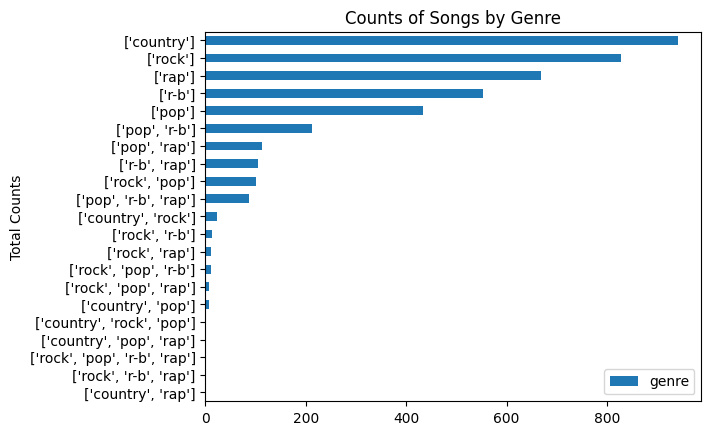

In [55]:
# Plot the total number of songs by genre
preproc_df["genre"].value_counts().sort_values(ascending = True).plot(
    kind = "barh",
    title = "Counts of Songs by Genre",
    xlabel = "Total Counts"
).legend(loc = "lower right");

## Descriptive Statistics

In [56]:
def descriptive_stats(tokens, num_tokens = 5, verbose=True) :
    """
        Given a list of tokens, print number of tokens, number of unique tokens, 
        number of characters, lexical diversity (https://en.wikipedia.org/wiki/Lexical_diversity), 
        and num_tokens most common tokens. Return a list with the number of tokens, number
        of unique tokens, lexical diversity, and number of characters. 
    
    """

    # Fill in the correct values here. 
    num_tokens = len(tokens) #length of tokens
    num_unique_tokens = (len(set(tokens)))
    lexical_diversity = (num_unique_tokens / num_tokens) #ratio of different unique word stems (types) to the total number of words (tokens).
    num_characters = sum(len(token) for token in tokens) #length of the string of tokens
    
    if verbose :        
        print(f"There are {num_tokens} tokens in the data.")
        print(f"There are {num_unique_tokens} unique tokens in the data.")
        print(f"There are {num_characters} characters in the data.")
        print(f"The lexical diversity is {lexical_diversity:.3f} in the data.")
    
        # print the five most common tokens
        print(Counter(tokens).most_common(5)) #p. 16 of textbook
        
    return([num_tokens, num_unique_tokens,
            lexical_diversity,
            num_characters])

# Build Word Cloud for each Genre

In [57]:
def wordcloud(word_freq, title=None, max_words=200, stopwords=None):

    wc = WordCloud(width=800, height=400, 
                   background_color= "black", colormap="Paired", 
                   max_font_size=150, max_words=max_words)
    
    # convert data frame into dict
    if type(word_freq) == pd.Series:
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq

    # filter stop words in frequency counter
    if stopwords is not None:
        counter = {token:freq for (token, freq) in counter.items() 
                              if token not in stopwords}
    wc.generate_from_frequencies(counter)
 
    plt.title(title) 

    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    
    
def count_words(df, column = 'tokens', preprocess = None, min_freq = 2):

    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # create counter and run through all data
    counter = Counter()
    df[column].map(update)

    # transform counter into data frame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'
    
    return freq_df.sort_values('freq', ascending=False)

The main 5 genres of interest are: country, rap, pop, rock, and R&B (r-b, as represented in the data).

In [58]:
# Create a subset dataframe for the genre
genre_list = ["rap", "country", "rock", "pop", "r-b"]

# WordCloud Function
def make_wordcloud(genre):
    genre_subset = preproc_df.loc[preproc_df["genre"] == str([genre])]
    genre_word_count = count_words(genre_subset)
    wordcloud(genre_word_count.squeeze(),
              title = "Genre: {}".format(genre))

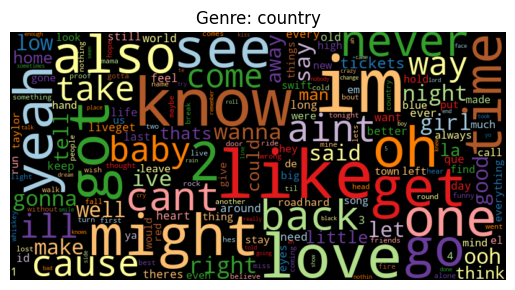

In [59]:
make_wordcloud("country")

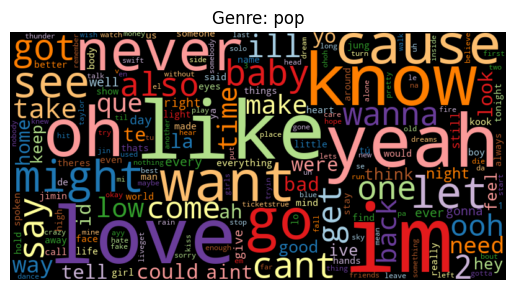

In [60]:
make_wordcloud("pop")

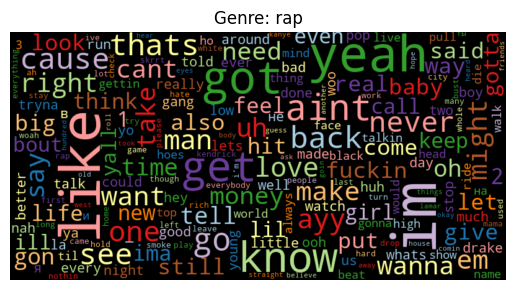

In [61]:
make_wordcloud("rap")

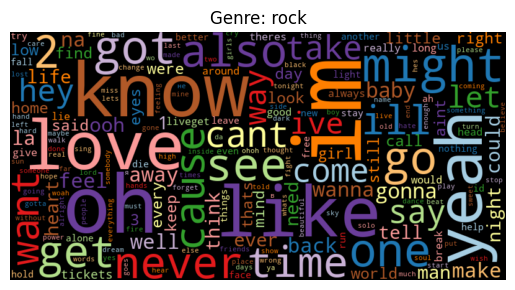

In [62]:
make_wordcloud("rock")

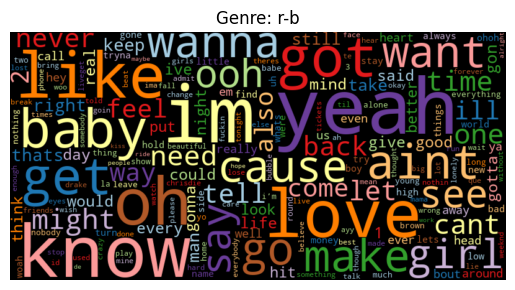

In [63]:
make_wordcloud("r-b")